# Dataset: Pairwise GNN approach

Get tracksters from a certain neighbourhood.

Construct a graph of the neighbourgood (or just a binary pair?) based on layer-clusters.

Classify cut-edges based on the node data.
Node data is enriched using message passing.

Maybe it's easier to start with binary pairs - although not computationaly optimal.

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [1]:
import uproot
import numpy as np
import awkward as ak
import networkx as nx

import matplotlib.pyplot as plt

from reco.event import get_candidate_pairs
from reco.graphs import create_graph
from reco.dataset import match_trackster_pairs, PointCloudPairs

from reco.plotting import plot_graph_3D


# plt.style.use('seaborn-whitegrid')
# data_root = "data/"
# raw_dir = "/Users/ecuba/data/multiparticle_complet"

data_root = "data"
ds_name = "CloseByTwoPion"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_name = f"{raw_dir}/new_ntuples_15101852_191.root"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = "/mnt/ceph/users/ecuba/multiparticle_10/"
# file_name = f"{raw_dir}/new_ntuples_14992862_1293.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
graphs = uproot.open({file_name: "ticlNtuplizer/graph"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

In [2]:
eid = 0

c_pairs, dst_map = get_candidate_pairs(tracksters, graphs, eid, max_distance=15)

gt_pairs = match_trackster_pairs(
    tracksters,
    simtracksters,
    associations,
    eid,
    energy_threshold=20,
    distance_threshold=15,
)

build supergraph

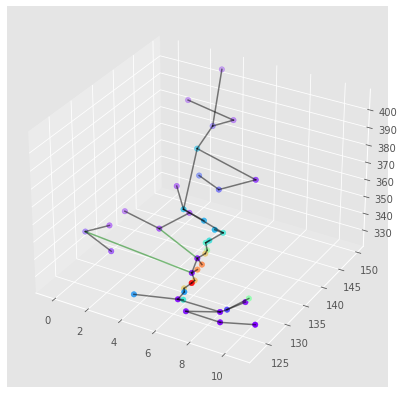

In [3]:
vx = tracksters["vertices_x"].array()[eid]
vy = tracksters["vertices_y"].array()[eid]
vz = tracksters["vertices_z"].array()[eid]
ve = tracksters["vertices_energy"].array()[eid]
vi = tracksters["vertices_indexes"].array()[eid]


ca, cb, _ = gt_pairs[0] # c_pairs for candidate pairs

ca_lc = set(vi[ca])
cb_lc = set(vi[cb])

cvx = ak.flatten([vx[ca], vx[cb]])
cvy = ak.flatten([vy[ca], vy[cb]])
cvz = ak.flatten([vz[ca], vz[cb]])
cve = ak.flatten([ve[ca], ve[cb]])
cvi = ak.flatten([vi[ca], vi[cb]])

G = create_graph(cvx, cvy, cvz, cve, trk_lc_index=cvi, N=1, higher_e=True)

for edge in G.edges:
    a, b = edge
    ai = G.nodes[a]["index"]
    bi = G.nodes[b]["index"]
    if (ai in ca_lc and bi in cb_lc) or (bi in ca_lc and ai in cb_lc):
        G.edges[edge]["color"] = "green"

plot_graph_3D(G, cve)

# The dataset

Following DGCNN, the graphs are constructed dynamically, therefore, the sample data should contain a two point clouds and a label.

In [4]:
ds = PointCloudPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=6,
    balanced=True,
    MAX_DISTANCE=15,
    ENERGY_THRESHOLD=20,
)

Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_157.root
Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_229.root
Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_100.root
Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_11.root
Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_116.root
Processing: /Users/ecuba/data/CloseByTwoPion/new_ntuples_15101852_141.root


In [5]:
len(ds[0][0])

4

4


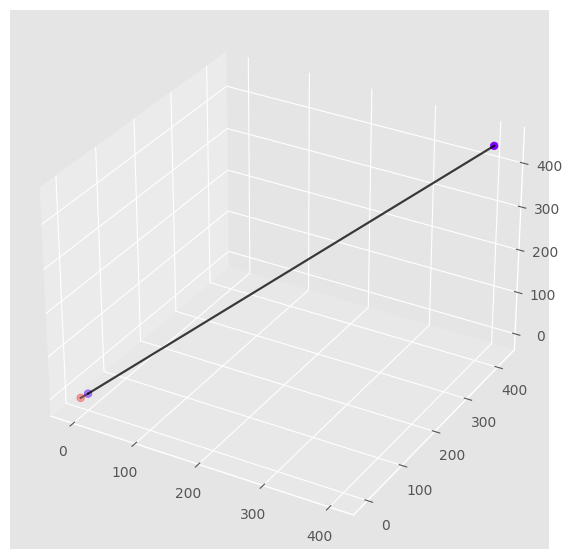

In [9]:
# pick a sample
x, labels = ds[3]

# remove padding (energy is 0)
truelen = min([i for i in range(len(x)) if x[i, 3] == 0] + [len(x)])
print(truelen)

x = x[:truelen]

# build the graph
G = create_graph(
    x[:,0].tolist(),
    x[:,1].tolist(),
    x[:,2].tolist(),
    x[:,3].tolist(),
    trk_lc_index=labels[:truelen],
    N=1,
    higher_e=True,
)

# color the cut edges
for edge in G.edges:
    a, b = edge
    if (G.nodes[a]["index"] != G.nodes[b]["index"]):
        G.edges[edge]["color"] = "red"

# plot it
plot_graph_3D(G, x[:,3])

## Padding

Padding not needed when using the batch size trick.

The number of points in each sample needs to be constant.

The padding doesn't really hurt as the padding nodes can be excluded from the knn and thus do not take part in the graph convolution.

In [9]:
lx = [len(sample[0][0]) for sample in ds]
max(lx)

144

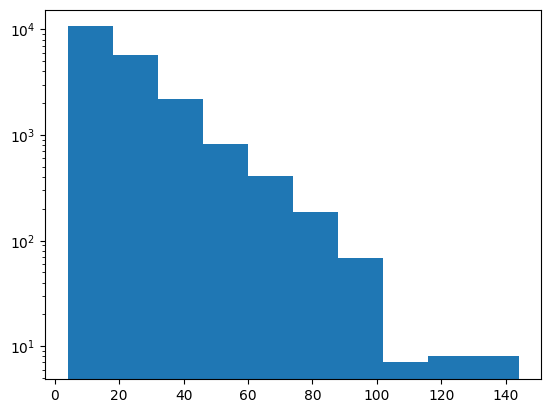

In [10]:
plt.hist(lx)
plt.yscale("log")
plt.show()